# Importando bibliotecas

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from src.preprocess.sequence_preprocessor import SequencePreprocessor
from src.graphing.temporal_threshold import TemporalThreshold

from notebooks.utils.view_network import plot_graph

# Verificando o pré-processamento

In [2]:
df = pd.read_csv('data/raw/active_alarms_prod.csv')
prepocessor = SequencePreprocessor()
df = prepocessor.select_features(df)

df.head()

,Alert ID,Alert Type,Alert Severity,Alert Description,Node ID,Node Name,First Occurrence,Last Occurrence
0,476a7e63-014b-46c0-abaf-e80dc0cacf14,OPENSHIFT_CLUSTER_PVC,2,NAMESPACE_PVC is over the limits 1 or 2 or 3 (...,f3ba8721-2bb0-46b3-b4dd-c9255bb7a3ad,SPCTP-V40HPP-SVT201-01,2025-10-06 08:55:11.921937,2025-10-06 08:55:11.921937
1,121548a8-9210-40a7-847f-988781502e3f,OPENSHIFT_CLUSTER_PVC,1,NAMESPACE_PVC is over the limits 1 or 2 or 3 (...,f3ba8721-2bb0-46b3-b4dd-c9255bb7a3ad,SPCTP-V40HPP-SVT201-01,2025-10-06 08:50:13.193322,2025-10-06 08:55:11.921937
2,a801690e-0074-4ad6-835f-9ca8da0c55e8,SOFTWARE_SERVICE_STATUS_INFO,2,NEW UNIT FILE (run-r2e9f4aaf23254cfcbf586daccc...,f02a8eab-0a93-4f87-90f9-3eb96aa9e1aa,RJBAR-TAIHUA-ESM31,2025-10-26 05:57:30.122030,2025-10-27 04:56:51.145393
3,776e0483-ac6f-48d0-921e-373a1cb3b5c7,CAPACITY_DISK_FREE_USED_PERCENT,1,USED % is over the limits 1 or 2 or 3 (Value =...,53c8586f-00c4-4f7f-b8b0-ccaa3cf535eb,SPCTP-TAIHUA-SVR14,2025-10-01 03:10:41.551299,2025-10-01 03:10:41.551299
4,e729be90-d67d-4741-a953-50f3603e5c80,SPARK_JVM_GARBAGE_COLLECTOR_YOUNG,1,JVM_GARBAGE_COLLECTOR_YOUNG is over the limits...,c60cc1af-aa30-491a-a3ef-55c6f8e4d8cd,spctp-v40hpp-svt231-14,2025-10-14 01:25:05.123944,2025-10-14 15:20:05.018794


In [3]:
nodes_df = prepocessor.group_by(df)

# Analisando os intervalos de tempo entre os alertas

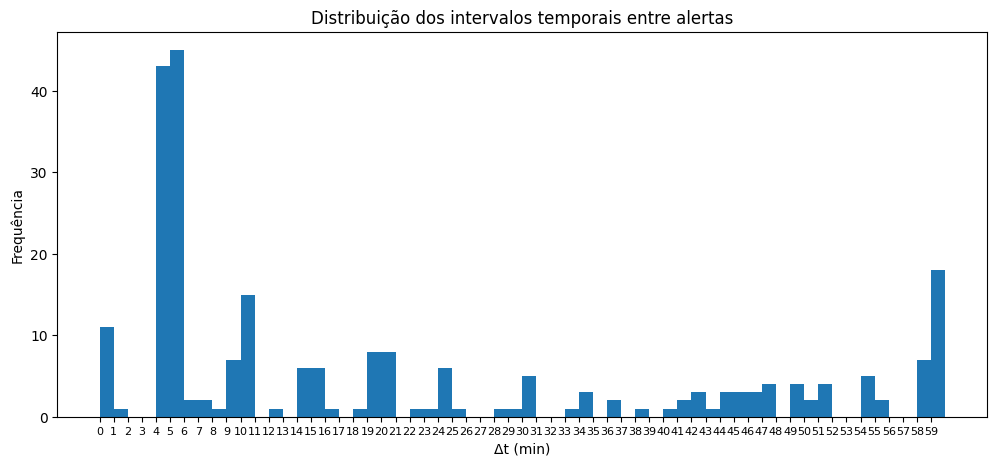

In [4]:
deltas = []
for node_df in nodes_df:
    node_df = node_df.sort_values('First Occurrence').reset_index()
    delta = node_df['First Occurrence'].diff().dropna()
    delta = delta[delta > pd.Timedelta(0)]
    deltas.append(delta)

delta_series = pd.concat(deltas)
delta_minutes = delta_series.dt.total_seconds() / 60
delta_minutes = delta_minutes[delta_minutes < 60]
plt.figure(figsize=(12,5))
plt.hist(delta_minutes, bins=60)
plt.xlabel("Δt (min)")
plt.ylabel("Frequência")
plt.xticks(range(0,60), rotation=0, fontsize=8)
plt.title("Distribuição dos intervalos temporais entre alertas")
plt.show()

# Criando os grafos de correlação temporal

In [31]:
threshold = pd.Timedelta(minutes=5)
graphs_list = []
temporal_threshold = TemporalThreshold()
for node_df in nodes_df:
    graph = temporal_threshold.to_graph(node_df, threshold=threshold)
    graphs_list.append(graph)

# Selecionando e plotando o melhor node

In [32]:
num_of_alerts_by_node = []
for node_df, graph in zip(nodes_df, graphs_list):
    node_name = node_df['Node Name'][0]
    num_of_alerts_by_node.append({
        'Node Name': node_name,
        'Number Of Alerts': len(graph),
        'Number of Sub-Graphs': nx.number_weakly_connected_components(graph),
        'Graph\'s Density': nx.density(graph)
    })
num_of_alerts_by_node = pd.DataFrame(num_of_alerts_by_node)
num_of_alerts_by_node = num_of_alerts_by_node.sort_values('Number Of Alerts', ascending=False)
num_of_alerts_by_node

,Node Name,Number Of Alerts,Number of Sub-Graphs,Graph's Density
56,SPCTP-IFOHPP-STR04,2004,1,0.414405
615,spctp-v40hpp-svt231-14,399,130,0.002626
286,UC13-PJ041-BARONEZA,264,1,0.217191
773,SPCTP-V40HPP-SVT201-01,237,33,0.010119
253,SPCTP-IFOHPP-SWT10,163,1,0.496327
...,...,...,...,...
215,spctp-vmgmt-cp3,1,1,0.000000
214,OPENSHIFT CLUSTER OVERVIEW - OCP- MGMT,1,1,0.000000
233,MASFR-V44NEC-SRV01,1,1,0.000000
231,SPCTP-TAIHUA-TSS11,1,1,0.000000


In [34]:
node_index = 286
graph = graphs_list[node_index]
node_df = nodes_df[node_index]

plot_graph(graph, f"graph_alerts_{node_df['Node Name'][0]}")